# Prédiction de l'appétence à un produit bancaire

Une grande banque offre à ses clients la possibilité de déposer la somme de leur choix sur un compte bloqué pour une période de temps déterminée. En contrepartie, les souscripteurs reçoivent des versements réguliers, pour un rendement habituellement plus avantageux qu'un simple placement sur compte-épargne. Ce produit s'appelle un dépôt à terme.

Pour des raisons évidentes, et aussi parce que les dépôts à terme inscrits au bilan permettent d'augmenter le montant des capitaux propres, cette banque a intérêt à vendre ce produit à ses clients. Elle a donc effectué des campagnes de marketing par téléphone pour enregistrer de nouvelles souscriptions.

Cependant, les campagnes de démarchage téléphonique peuvent être perçues par les consommateurs comme intrusives et détériorer l'image de marque de la banque. D'autre part, ces campagnes ont bien sûr un coût, puisqu'il faut payer des commerciaux. Il est donc préférable de limiter le nombre d'appels en ciblant au mieux les clients susceptibles de souscrire un dépôt à terme.

Dans cette perspective, nous disposons d'un jeu de données collectées lors de précédentes campagnes de démarchage, ainsi que de données extérieures à la banque, relatives au contexte économique et social. Nous allons maintenant commencer l'étude en chargeant ces données.

In [5]:
import eda_utilities as eda

eda.settings()
initial_data = eda.load_initial_data()

Chaque ligne de ce tableau correspond au dernier appel d'une série de contacts téléphoniques relatifs à un client. Certaines caractéristiques de l'appel et du client ont été enregistrées, ainsi que le résultat sous forme de la variable HAS_SUBSCRIBED, qui vaut "Yes" si le client a souscrit, et "No" sinon. C'est donc cette variable qu'il convient de prédire.

## Caractéristiques de la cible HAS_SUBSCRIBED

La cible est donc une variable binaire. Dans cet échantillon de 45136 observations, une large proportion concerne des refus, puisque seuls 5253 clients ont souscrit, soit environ 11,64% des clients contactés. Les données disponibles sont donc largement déséquilibrées, ce dont nous tiendrons compte lors de la recherche du modèle optimal.

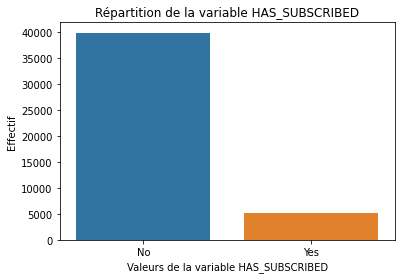

In [9]:
eda.illustrate_target(initial_data)

Dans la suite, on considérera HAS_SUBSCRIBED comme une variable binaire 0-1. Nous allons maintenant étudier les autres variables disponibles, et discuter de leur lien avec la cible.

In [10]:
eda.make_has_subscribed_binary(initial_data)

## Lien entre la variable ACCOUNT_BALANCE et la cible

In [12]:
initial_data.loc[(initial_data.BALANCE.le(-1)), 'SUBSCRIPTION'].sum()

210

La propension à acheter un produit bancaire semble intuitivement lié à la quantité d'argent disponible, donc probablement au solde du compte bancaire au moment de la décision. La variable ACCOUNT_BALANCE représente cette quantité, à la différence que certaines valeurs ne sont pas précisément connues : 0 peut ainsi véritablement désigner un compte vide, ou seulement l'absence d'argent disponible, c'est-à-dire un solde négatif (cette information a été obtenue auprès de la banque). Cette situation concerne 3512 clients, ce qui est une part relativement faible de l'échantillon.

D'autre part, on peut noter un fait a priori étonnant : une valeur strictement négative de ACCOUNT_BALANCE n'implique pas un refus de souscription. En effet, 210 ont souscrit malgré un solde négatif. Cela suggère que ACCOUNT_BALANCE représente plutôt le solde d'un compte courant qu'une réelle épargne disponible.

Malgré tout, on observe une corrélation significativement non-nulle avec la cible : plus ACCOUNT_BALANCE augmente, plus le client est susceptible de souscrire. La relation semble non-linéaire, car le rho de Spearman est deux fois plus grand que la corrélation de Pearson.

In [13]:
eda.correlation_target_balance(initial_data)

Mesures de corrélation entre la cible et ACCOUNT_BALANCE,
Corrélation de Pearson,0.053101
Rho de Spearman,0.100324


En étudiant plus précisément la distribution de ACCOUNT_BALANCE, nous nous sommes alors rendu compte que cette variable possède un grand nombre d'outliers. En effet, si la médiane de cette variable est 447,5, on constate des valeurs supérieures à 10000 chez 829 clients, et supérieures à 50000 chez 18 clients.

Cependant, si on applique un clip sur les valeurs supérieures à 4000, on observe que la corrélation est nettement plus élevée (4000 est approximativement le seuil qui maximise la corrélation).

In [17]:
eda.correlation_target_balance(initial_data, upper_clip=4000, lower_clip=-4000)

Mesures de corrélation entre la cible et ACCOUNT_BALANCE,
Corrélation de Pearson,0.089934
Rho de Spearman,0.100503


Nous avons donc décidé de conserver cette transformation de ACCOUNT_BALANCE. (Notons que les outliers négatifs ne semblent pas avoir la même influence, mais que nous les avons tout de même traités de manière symétrique.)

In [18]:
eda.clip_balance(initial_data, upper_clip=4000, lower_clip=-4000)

On voit alors sur un violon-plot que les distributions de ACCOUNT_BALANCE sont différentes selon que HAS_SUBSCRIBED vaut 0 ou 1, ce qui est confirmé par un test de Kolmogorov-Smirnov.

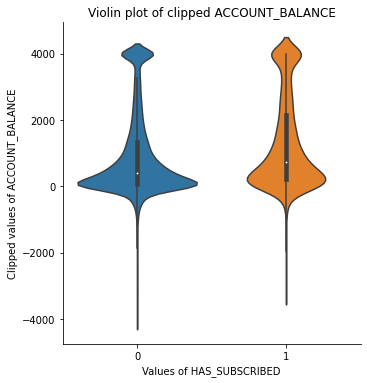

La p-valeur du test de Kolmogorov-Smirnov est de 3.5537234126602085e-68 : ACCOUNT_BALANCE n'a donc pas la même distribution selon que la cible vaut 0 ou 1.


In [19]:
eda.plot_balance_knowing_target(initial_data)
eda.test_independence_between_balance_and_target(initial_data)

Au final, si ACCOUNT_BALANCE est bien lié à la cible, il semble être un faible prédicteur. Nous utiliserons __le feature ACCOUNT_BALANCE, après avoir clippé la variable et l'avoir normalisée par 8000__ (la distance entre les clips supérieurs et inférieurs).

## Lien entre la variable JOB_TYPE et la cible

On doit alors chercher un autre marqueur de l'aisance financière des clients. La variable JOB_TYPE semble indiquée, puisque la catégorie professionnelle est corrélée au niveau de vie.

Tout d'abord, calculons les différences de taux de souscription selon la catégorie professionnelle.

In [20]:
eda.target_by_job_type(initial_data)

,Number of subscriptions,Number of clients,Proportion of subscription
JOB_TYPE,,,
Blue-collar worker,705,9726,0.072486
Entrepreneur,120,1483,0.080917
House keeper,109,1239,0.087974
Services,367,4148,0.088476
Technician,833,7586,0.109808
Freelance,186,1577,0.117945
Admin,627,5161,0.121488
Manager,1295,9445,0.137110
Unemployed,201,1301,0.154497


Les proportions semblent très différentes, et un test du chi-2 confirme que ces différences ne sont pas seulement statistiques, ni dues à des différences de taille d'échantillons.

In [21]:
eda.test_independence_between_target_and_job_type(initial_data)

La p-valeur du test du chi2 d'indépendance est de 1.7149963803162842e-171 : JOB_TYPE n'est donc pas indépendant de la cible.


Nous remarquons ensuite que les étudiants et les retraités sont les deux classes les plus susceptibles de souscrire, suivis par les chômeurs. Ces catégories ne sont pourtant pas normalement associées à une plus grande aisance financière. Nous donnerons une explication dans les prochaines sections.

Quoi qu'il en soit, cette variable contient de l'information sur la cible, et il faut maintenant l'encoder. Or il semble problématique d'utiliser le one-hot encoding en raison du grand nombre de catégories, d'autant que certaines catégories semblent proches ("Entrepreneur", "House keeper" et "Services" par exemple). D'autre part, le target encoding donne un résultat peu convaincant (corrélation de 0.10 environ). Nous réservons donc notre décision pour le moment.

Enfin, la variable JOB_TYPE contient 286 valeurs manquantes, que nous proposons de compléter en utilisant la variable AGE : les moins de 25 ans sont généralement des étudiants, les plus de 60 ans des retraités, et on peut compléter par la catégorie professionnelle majoritaire pour les autres.

In [23]:
eda.remove_missing_values_for_job_type(initial_data)

## Lien entre la variable MARITAL_STATUS et la cible

La variable MARITAL_STATUS est une variable catégorielle. Elle possède 1128 valeurs manquantes et est répartie de la manière suivante :

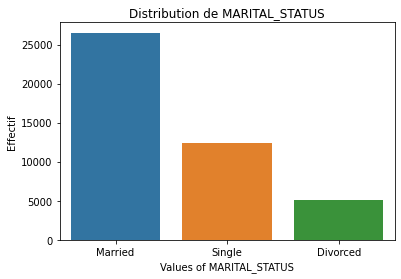

In [25]:
eda.illustrate_status(initial_data)

Ces catégories ont des comportements différents par rapport au produit proposé, ce qui peut être confirmé par un test d'indépendance du chi2 :

In [26]:
eda.target_by_marital_status(initial_data[~initial_data.JOB_TYPE.isin(['Retired'])])
eda.test_independence_between_target_and_marital_status(initial_data)

,Number of subscriptions,Number of clients,Proportion of subscription
STATUS,,,
Married,2301,24822,0.092700
Divorced,481,4638,0.103708
Single,1843,12356,0.149158


La p-valeur du test du chi2 d'indépendance est de 3.7066582496688655e-42 : MARITAL_STATUS n'est donc pas indépendant de la cible.


## Lien entre MARITAL_STATUS et JOB_TYPE

Cependant, il est évident que la catégorie professionnelle est un indicateur du statut marital, notamment parce que les étudiants sont habituellement célibataires et les retraités mariés. Vérifions d'abord cette intuition.

In [27]:
eda.marital_status_by_job_type(initial_data)

MARITAL_STATUS,Divorced,Married,Single,Subscription rate
JOB_TYPE,,,,
Admin,727,2623,1686,0.121488
Blue-collar worker,743,6996,2037,0.073733
Entrepreneur,177,1045,234,0.080917
Freelance,138,970,436,0.117945
House keeper,177,890,141,0.087974
Manager,1079,5233,2869,0.137110
Retired,408,1678,106,0.226465
Retraité,1,18,2,0.100000
Services,530,2340,1172,0.088476


On pourrait alors penser que le fort taux de souscription chez les étudiants est dû à la forte proportion de célibataires, dont on a vu qu'ils étaient plus susceptibles de souscrire. Plus généralement, on pourrait penser que les taux de souscription observés pour chaque catégorie s'expliquent essentiellement par le statut marital de ses membres.

Pour vérifier cette hypothèse, nous proposons d'essayer de prédire le taux de souscription dans chaque catégorie en fonction du taux de célibataires et du taux d'individus mariés dans cette catégorie. Nous avons effectué une régression linéaire et comparé les valeurs observées du taux de souscription avec les prédictions dans le modèle.

In [28]:
eda.show_predictions_subscription_rate(initial_data)

MARITAL_STATUS,Proportion Single,Proportion Married,Subscription rate,Predictions
JOB_TYPE,,,,
Admin,0.334790,0.520850,0.121488,0.136182
Blue-collar worker,0.208367,0.715630,0.073733,0.121441
Entrepreneur,0.160714,0.717720,0.080917,0.109200
Freelance,0.282383,0.628238,0.117945,0.132569
House keeper,0.116722,0.736755,0.087974,0.099503
Manager,0.312493,0.569981,0.137110,0.134968
Retired,0.048358,0.765511,0.226465,0.084356
Retraité,0.095238,0.857143,0.100000,0.105178
Services,0.289955,0.578921,0.088476,0.129923


Les prédictions semblent plutôt bonnes. Le coefficient R2 est supérieur à 0.85, la p-valeur du test de Fisher est inférieure à 10e-5, les p-valeurs de Student sont relativement faibles...

In [29]:
eda.show_results_linear_regression_subscription_rate(initial_data)

                        Results: Ordinary least squares
Model:                  OLS               Adj. R-squared (uncentered): 0.866    
Dependent Variable:     Subscription rate AIC:                         -34.5596 
Date:                   2021-03-12 14:46  BIC:                         -33.5898 
No. Observations:       12                Log-Likelihood:              19.280   
Df Model:               2                 F-statistic:                 39.88    
Df Residuals:           10                Prob (F-statistic):          1.72e-05 
R-squared (uncentered): 0.889             Scale:                       0.0028261
-----------------------------------------------------------------------------------
                         Coef.     Std.Err.      t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------------------
Proportion Single        0.2610      0.0522    5.0017    0.0005    0.1447    0.3772
Proportion Married       0.0937      0.02

mais la prédiction correspondant aux retraités est particulièrement mauvaise en comparaison avec les autres. Un test de détection de valeurs aberrantes de Bonferonni confirme que cette valeur est significativement différentes des autres observations relativement à ce modèle de régression linéaire.

In [30]:
eda.bonferroni_outlier_test_retired(initial_data)

Bonferroni outlier test p-value: 1.0


La catégorie des retraités est donc différente des autres, et n'est pas bien expliquée par le modèle de régression linéaire. Cependant, si on enlève cette observation et qu'on réentraîne le modèle sur les valeurs restantes, on obtient un très bon modèle :

In [31]:
eda.show_results_linear_regression_subscription_rate_without_retired(initial_data)

                         Results: Ordinary least squares
Model:                  OLS               Adj. R-squared (uncentered): 0.975     
Dependent Variable:     Subscription rate AIC:                         -51.3774  
Date:                   2021-03-12 14:46  BIC:                         -50.5816  
No. Observations:       11                Log-Likelihood:              27.689    
Df Model:               2                 F-statistic:                 212.7     
Df Residuals:           9                 Prob (F-statistic):          2.65e-08  
R-squared (uncentered): 0.979             Scale:                       0.00046591
------------------------------------------------------------------------------------
                         Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
------------------------------------------------------------------------------------
Proportion Single        0.2940      0.0217    13.5611    0.0000    0.2449    0.3430
Proportion Married       0.05

La p-valeur du test de Fisher est très faible, et les deux variables sont maintenant significatives au seuil de 3% d'erreur. Même si on pourrait encore utiliser d'autres outils de validation pour ce modèle, on peut considérer que le taux de souscription d'une catégorie professionnelle (autre que celle des retraités) est très bien expliqué à l'aide des taux de souscription relatif aux différents statuts maritaux.

In [32]:
eda.show_predictions_subscription_rate_without_retired(initial_data)

MARITAL_STATUS,Proportion Single,Proportion Married,Subscription rate,Predictions
JOB_TYPE,,,,
Admin,0.334790,0.520850,0.121488,0.136584
Blue-collar worker,0.208367,0.715630,0.073733,0.122279
Entrepreneur,0.160714,0.717720,0.080917,0.110096
Freelance,0.282383,0.628238,0.117945,0.133191
House keeper,0.116722,0.736755,0.087974,0.100477
Manager,0.312493,0.569981,0.137110,0.135469
Retired,0.048358,0.765511,0.226465,0.085450
Services,0.289955,0.578921,0.088476,0.130463
Student,0.934807,0.058564,0.285408,0.248483


Ces résultats confirment donc que le taux de souscription parmi une catégorie professionnelle est très bien expliqué par les groupes de même statut marital qui la composent, sauf pour les retraités. Nous en concluons que la variable JOB_TYPE est inutile en présence de MARITAL_STATUS : __nous ne garderons pas JOB_TYPE, mais utiliserons une indicatrice valant 1 pour les retraités__. Le taux de souscription chez les célibataires étant également beaucoup plus élevé que pour les autres catégories, __nous transformerons MARITAL_STATUS en une indicatrice valant 1 pour les célibataires__.

D'autre part, on voit en particulier dans le dernier tableau ci-dessous que, sauf chez les étudiants qui sont majoritairement célibataires, le statut marital majoritaire est d'être marié. On peut donc utiliser la variable JOB_TYPE pour compléter les données manquantes de la variable MARITAL_STATUS : on considérera que les étudiants sont tous célibataires (à défaut d'information à ce sujet) et que les autres sont mariés.

Enfin, nous pouvons compléter notre intuition concernant le public le plus susceptible d'être intéressé par les dépôts à terme : nous avons vu dans les deux dernières sections que les retraités et les célibataires étaient particulièrement intéressés par ce produit, par opposition aux personnes actives et mariées qui en sont peu friandes. En effet, les dépôts à terme sont particulièrement adaptés pour des personnes qui ont un capital dormant qu'elles n'ont pas l'intention d'utiliser dans l'immédiat. On peut alors imaginer que les personnes mariées et actives ont généralement des prêts à rembourser et une famille à faire vivre, ce qui peut les amener à préférer garder une réserve d'argent disponible, tandis que les retraités par exemple n'auraient pas ou plus de projet coûteux à réaliser. 

## Lien entre la variable AGE et la cible

Ainsi, la cible semble d'emblée liée à l'âge : les plus jeunes et les plus vieux semblent plus susceptibles de souscrire. Etudions alors la variable AGE.

C'est une variable continue. Elle possède une valeur aberrante de 123 ans pour 1806 personnes, qui correspond en fait à une valeur manquante. Nous proposons de compléter ces valeurs en les remplaçant par l'âge moyen parmi la catégorie professionnelle concernée. En effet, on peut voir sur le tableau ci-dessous que ces valeurs sont plausibles.

In [34]:
eda.show_mean_age_by_job_type(initial_data)

,Mean age
JOB_TYPE,
Admin,39.277778
Blue-collar worker,40.201330
Entrepreneur,42.184100
Freelance,40.462804
House keeper,46.347826
Manager,40.436297
Retired,61.654851
Retraité,67.176471
Services,38.740704


In [35]:
eda.replace_age123_by_mean_in_job_type(initial_data)

On peut alors étudier la distribution de la variable AGE.

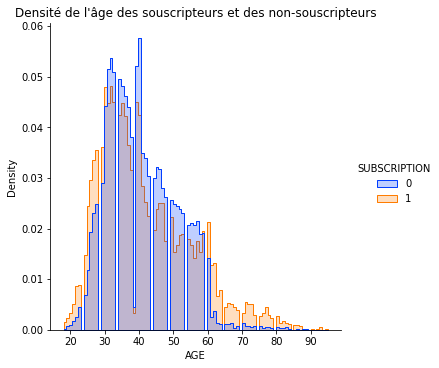

In [36]:
eda.plot_age_histogram(initial_data)

Il apparaît alors clairement que la distribution de l'âge des souscripteurs est plus concentrée sur les plus jeunes et les plus vieux. En dehors de cela, les distributions ne sont pas facilement discernables. __Nous avons donc choisi de résumer la variable AGE à l'indicatrice (AGE > 60) d'une part, et à l'indicatrice (AGE<25) d'autre part__.

Avec ces choix, il n'est alors plus nécessaire d'utiliser une technique de complétion sophistiquée pour éviter les pics visibles sur l'histogramme : beaucoup d'individus se voient attribué un âge d'environ 40 ans, mais ces âges ne sont pas ensuite retenus dans nos features.

Cependant, __nous utiliserons tout de même la variable AGE normée avec les forêts aléatoires__.

## Lien entre la variable DATE et la cible

Ensuite, il est naturel de se demander si certaines périodes sont plus propices à la vente de dépôts à terme.

La répartition de la variable en fonction de l'année montre que les campagnes ont surtout été menées en 2008, puis en moindre mesure en 2009 et 2010.

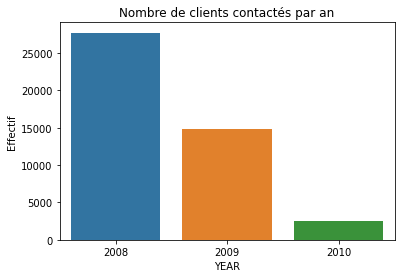

In [37]:
eda.plot_date_by_year(initial_data)

On peut également visualiser cette répartition par mois.

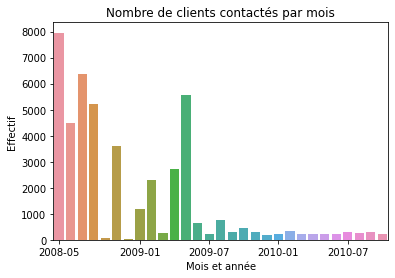

In [38]:
eda.plot_date_year_and_month(initial_data)

Nous avons également observé le jour de la semaine de chacune des dates. On peut constater des différences significatives entre les jours, en effectuant par exemple un test d'indépendance du chi2 entre le jour de la semaine et le taux de souscription. 

In [39]:
eda.show_table_subscription_by_weekday(initial_data)
eda.test_independence_between_target_and_weekday(initial_data)

,Subscription rate
WEEKDAY,
Saturday,0.100000
Monday,0.101326
Friday,0.113281
Wednesday,0.121038
Tuesday,0.121628
Thursday,0.125026
Sunday,0.200000


La p-valeur du test du chi2 d'indépendance est de 0.0 : le jour de la semaine n'est donc pas indépendant de la cible.


Cependant, __nous choisissons de ne pas garder de feature basé sur le jour de la semaine__, car cette corrélation avec la cible est probablement artificielle : les (plus rares) contacts ayant lieu le samedi ou le dimanche ont probablement été programmés avec l'assentiment du client, et on sait alors que celui-ci est plus enclin à souscrire. Les autres différences hors week-end pourraient s'expliquer de différentes manières, sans qu'il soit pertinent de conseiller à la banque d'appeler ses clients le jeudi plutôt que le lundi. D'autre part, les données disponibles sont relatives non au premier contact, mais au dernier, et il est de toute façon impossible de proposer une stratégie permettant d'aboutir à un dernier contact un certain jour de la semaine.

Par contre, en gardant seulement le mois et plus le jour, on obtient des différences significatives et plus pertinentes.

In [40]:
eda.show_table_subscription_by_month(initial_data)

,Subscription rate
MONTH,
May,0.067195
July,0.090935
November,0.094223
January,0.101212
June,0.102228
August,0.110133
February,0.166478
April,0.196794
October,0.437669


On distingue alors grossièrement deux périodes peu propices aux campagnes de démarchage : avant et après Noël, et avant et pendant les vacances scolaires d'été. On peut penser qu'à ces périodes, le client anticipe des dépenses importantes. __Nous conserverons donc le feature du mois pour notre étude, avec un target encoding__.

## Lien entre la variable EDUCATION et la cible

Nous nous intéressons maintenant à la variable EDUCATION. Cette variable contient 1853 valeurs manquantes, que nous proposons de compléter en utilisant la variable JOB_TYPE comme décrit ci-dessus.

Visualisons la répartition de cette variable :

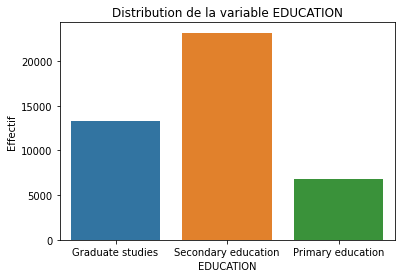

In [42]:
eda.plot_education(initial_data)

Cette variable est sensiblement liée à la cible :

In [43]:
eda.show_table_subscription_by_education(initial_data)

,Subscription rate
EDUCATION,
Primary education,0.086182
Secondary education,0.104856
Graduate studies,0.149337


Il semble donc y avoir un léger signal dans cette variable, qui d'autre part ne semble pas intuitivement corrélée avec le fait d'être ou non retraité, ou au statut marital par exemple. __Nous décidons donc d'inclure cette variable avec un encodage one-hot__.

## Lien entre les variables HAS_HOUSING_LOAN, HAS_PERSO_LOAN et la cible

Ces deux variables représentent un prêt (immobilier ou à la consommation) pesant sur le client. Intuitivement, un client doit rembourser un prêt est contraint, ne peut pas disposer aussi librement de son épargne, et aura donc tendance à refuser un dépôt à terme.

Voici la répartition de ces deux variables.

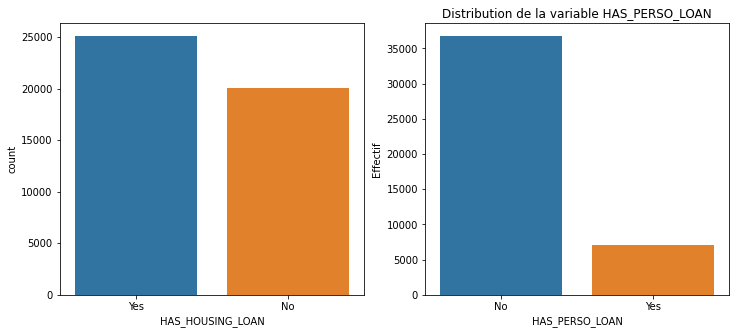

In [44]:
eda.plot_has_housing_and_perso_loan(initial_data)

La variable HAS_HOUSING_LOAN n'a pas de valeur manquante, mais la variable HAS_PERSO_LOAN en a 1354. Nous supposons que ces valeurs correspondent à une absence de prêt personnel, ce qui correspond également à compléter par la valeur la plus fréquente de la variable. D'autre part, __nous encoderons les deux variables comme des binaires 0-1__.

__Nous construisons également une variable HAS_LOAN indiquant quels clients possèdent ou un prêt immobilier, ou un prêt personnel__. Calculons alors les différentes corrélations avec la cible.

In [46]:
eda.show_correlation_loan_variables_with_target(initial_data)

,Correlation with target
HAS_PERSO_LOAN,-0.067503
HAS_HOUSING_LOAN,-0.138813
HAS_LOAN,-0.159144


Combiner les deux types de prêt permet donc d'obtenir une meilleure corrélation. Certes, ce nouveau feature est également corrélé avec HAS_HOUSING_LOAN et HAS_PERSO_LOAN, mais nous nous proposons d'utiliser tout de même les trois features conjointement, quitte à se rendre compte lors des tests que certains de ces features sont problématiques ou inutiles.

## Lien entre HAS_DEFAULT et la cible

La variable binaire HAS_DEFAULT indique si un client a déjà fait défaut. Elle trahit donc l'aisance financière d'un individu, et devrait donc être négativement corrélée avec la cible.

On peut visualiser sa répartition, et calculer sa corrélation avec la cible.

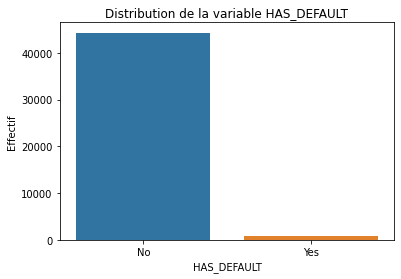

La corrélation avec la cible est de -0.022233247373426582.


In [47]:
eda.plot_has_default(initial_data)
eda.compute_correlation_has_default_target(initial_data)

__Nous décidons de garder la variable en l'encodant comme une binaire 0-1__, même si la corrélation semble trop faible pour que nous la gardions finalement dans notre modèle.

## Lien entre la variable RESULT_LAST_CAMPAIGN et la cible

Les campagnes de marketing de la banque se sont étendues sur au moins deux ans, et certains clients ont pu être contactés plusieurs fois. La variable RESULT_LAST_CAMPAIGN indique le résultat de ce dernier contact, en particulier s'il a donné lieu à une première souscription.

Cependant, cette variable possède de nombreuses valeurs manquantes : 81,84% de toutes les valeurs. Observons l'évolution de ces valeurs manquantes : nous représentons pour chaque mois le pourcentage de valeurs manquantes parmi tous les données collectées pendant ce mois.

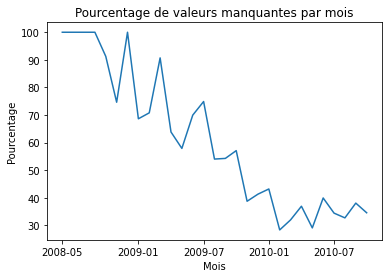

In [50]:
eda.missing_values_percentage_of_result_by_month(initial_data)

Ainsi, on imagine que la banque, après avoir contacté tous les clients qu'elle voulait cibler, a commencé à reprendre contact avec certains clients déjà approchés. Le taux de nouveaux clients, contactés pour la première fois, a diminué jusqu'à se statbiliser autour de 30%.

Il paraît ainsi cohérent de penser que ces valeurs manquantes correspondent, non pas à des oublis de la part des commerciaux, mais à des clients pour lesquels aucunes données concernant la dernière campagne n'existent. Ceci est d'ailleurs confirmé par le fait que les valeurs manquantes de RESULT_LAST_CAMPAIGN correspondent (sauf pour cinq observations) à un valeur pour NB_DAYS_LAST_CONTACT de -1, et non NA.

Il ne semble donc pas problématique de conserver cette variable. Nous proposons de compter les valeurs manquantes comme une nouvelle catégorie "First contact", sauf pour les cinq observations ayant des valeurs positives de NB_DAY_LAST_CONTACT, qu'on peut comptabiliser comme "Other".

D'autre part, lorsqu'elle est renseignée, cette variable est très intéressante, comme le montre le tableau suivant.

In [51]:
eda.fill_missing_values_result_last_campaign(initial_data)
eda.show_table_subscription_by_result_last_campaign(initial_data)

,Subscription rate
RESULT_LAST_CAMPAIGN,
Fail,0.126050
First contact,0.091271
Other,0.167665
Success,0.645357


Tout contact antérieur avec le client est donc bénéfique, en particulier en cas de vente. Il s'agit alors peut-être d'un effet de pied-dans-la-porte, ou alors le client est plus enclin à acquérir un produit avec lequel il a été familiarisé une première fois.

Cependant, seule la catégorie "Success" semble avoir un impact indubitable, __nous transformerons donc RESULT_LAST_CAMPAIGN en indicatrice valant 1 quand la dernière campagne a été un succès__.

## Lien entre la variable NB_DAYS_LAST_CONTACT et la cible

Comme expliqué précédemment, la variable NB_DAY_LAST_CONTACT indique le nombre de jours passés depuis le dernier contact avec le client, ou -1 si aucun contact n'a eu lieu.

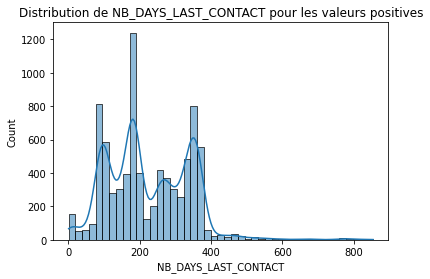

In [52]:
eda.plot_nb_days_last_contact(initial_data)

In [54]:
initial_data['NB_DAY_LAST_CONTACT'].ge(500).sum()

102

Nous avons représenté ci-dessus la distribution de la variable pour les valeurs positives. Celle-ci est clairement multimodale avec un maximum local tous les quatre-vingt dix jours environ, ce qui pourrait suggérer que les campagnes sont relancées tous les trois mois.

D'autre part, on observe qu'il y a 102 valeurs supérieures à 500, que l'on pourrait considérer comme des outliers, et qu'il faudra traiter.

Ces outliers et les valeurs -1 sont probablement la cause de la mauvaise corrélation entre NB_DAY_LAST_CONTACT et la cible : {{'%.3f' % initial_data[['NB_DAY_LAST_CONTACT', 'SUBSCRIPTION']].corr()['SUBSCRIPTION'][0]}}. __Une solution est alors de regrouper (binning) la variable en quatre bins déterminés automatiquement à l'aide des quartiles de la distribution représentée ci-dessus : les données positives sont remplacées par le centre du bin correspondant, et les -1 sont remplacés par le plus grand centre (le centre du quatrième et dernier groupe)__. On résout en même temps le problème des outliers.

NB : Les quatre bins correspondent approximativement aux quatre modes principaux de la distribution ci-dessus, c'est-à-dire peut-être à quatre campagnes de marketing.

Les fonctions suivantes calculent le nouveau feature BINNED_NB_DAYS_LAST_CONTACT et sa corrélation avec la cible.

In [38]:
eda.compute_binned_nb_days_last_contact(initial_data)
eda.compute_correlation_binned_nb_days_last_contact_target(initial_data)

La corrélation entre le nouveau feature et la cible est de -0.20202195227443118.


Cette corrélation est deux fois plus grande en valeur absolue qu'avec la variable originale : il est d'ailleurs plus intuitif de penser que cette corrélation devrait être négative.

## Lien entre les variables NB_CONTACTS, NB_CONTACTS_LAST_CAMPAIGN et la cible

Cette variable donne le nombre de contacts ayant eu lieu avec le client pendant cette campagne et pendant la dernière respectivement.

Si on trace la distribution de la variable NB_CONTACTS, on obtient le graphe suivant.

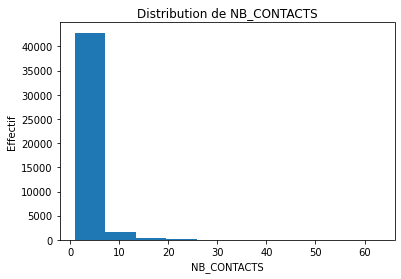

In [35]:
eda.histogram_nb_contacts(initial_data)

On voit qu'il y a des outliers, et __on les traite en clippant la variable au dessus de 15, puis en normant le feature obtenu par 15__.

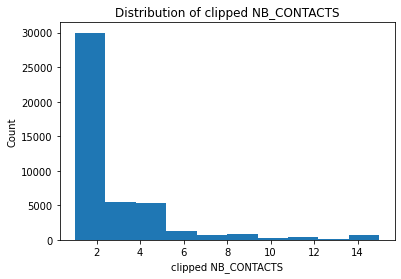

In [36]:
eda.clip_nb_contacts(initial_data)
eda.histogram_clipped_nb_contacts(initial_data)

__On traite la variable NB_CONTACTS_LAST_CAMPAIGN exactement de la même manière__.

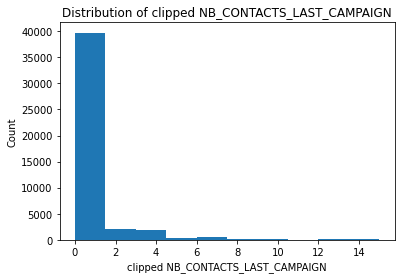

In [37]:
eda.clip_nb_contacts_last_campaign(initial_data)
eda.histogram_clipped_nb_contacts_last_campaign(initial_data)

## Traitement des variables socio-économiques

Les variables proposées sont de deux types : le taux de variation de l'emploi est trimestriel, tandis que l'indice des prix à la consommation et l'indice de confiance des consommateurs sont mensuels.

Certaines données sont manquantes. Une complétion parfaite aurait pu être obtenue pour la variable trimestrielle, mais par simplicité, nous appliquerons une complétion par interpolation, puis un scaling.

## Traitement des variables CONTACT et DURATION_CONTACT

La variable DURATION_CONTACT indique la durée du dernier appel avec le client avant d'obtenir une vente ou un refus. Lorsque la banque décide ou non d'appeler un client, elle ne dispose évidemment pas de cette information, aussi nous supprimerons cette variable.

Enfin, nous n'avons pas trouvé de lien intéressant entre la cible et CONTACT, aussi n'avons-nous pas gardé cette variable.